# AmazonReviews Naive Bayes Assignment

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd #for data frames
import numpy as np #numpy array operations
import nltk #natural lang processing, for processing text
import string
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import pickle
import seaborn as sn

import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

from sklearn.metrics import average_precision_score,f1_score,precision_score,recall_score,auc,log_loss,confusion_matrix


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pickle_in=open("cleanedData.pickle","rb")
final = pickle.load(pickle_in)

In [3]:
pickle_in = open("BOW_tfidf_avgW2V_TfidfW2V.pickle","rb")
count_vect = pickle.load(pickle_in) #BOW
final_counts = pickle.load(pickle_in) #BOW

tf_idf_vect = pickle.load(pickle_in) #TFIDF
final_tf_idf = pickle.load(pickle_in) #TFIDF
features = pickle.load(pickle_in) #TFIDF

w2v_model = pickle.load(pickle_in) #w2v
words = pickle.load(pickle_in) #w2v

sent_vectors = pickle.load(pickle_in) #avg W2V

C:\Users\Dell\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
# Weighted TF_IDF W2V
pickle_in =open("WiightedTfidfW2V.pickle","rb")
tfidf_sent_vectors = pickle.load(pickle_in)

In [5]:
final.shape

(364171, 11)

In [6]:
scores = final['Score'].get_values()
len(scores)

364171

In [7]:
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in range(0,364171):
    final_scores.append(li(scores[i]))

### Getting Best Alpha Value Using Cross Validation Using Time Based Split 

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import BernoulliNB

li_of_scoring = ['Accuracy Score','F1 Score','Precision Score',
                    'Recall Score','AUC','Log-Loss'] 

def alpha_cross_validation(x_1,y_1,n_alpha,score):
    #list of alpha values
    liOfAlphas = list(range(1,n_alpha));
    
    #empty list to hold CV scores/accuracy
    cv_scores = []
    
    
    
    for alph in liOfAlphas:
        
        tscv = TimeSeriesSplit(n_splits=5)
        acc_sum=0
        cnt=0
        for train_index, test_index in tscv.split(x_1):
            X_train, X_test = x_1[train_index], x_1[test_index]
            Y_train, Y_test = y_1[train_index], y_1[test_index]
            
            #alpha is used to avoide Errors, its ntg but Laplace Smoothing
            # Binarize=0 or any num indicates it converts every feature into bin value as it supports only bin values
            clf = BernoulliNB(alpha=alph, binarize=0.0, class_prior=None, fit_prior=True)
            clf.fit(X_train,Y_train)
            
            pred = clf.predict(X_test)
            
            acc = 0
            
            if(score == 1):
                acc = accuracy_score(Y_test, pred, normalize=True )*float(100)
            
            elif(score == 2):
                acc = f1_score(Y_test, pred)*float(100)
            elif(score == 3):
                acc = precision_score(Y_test, pred)*float(100)
            elif(score == 4):
                acc = recall_score(Y_test, pred)*float(100)
            elif(score == 5):
                fpr, tpr, thresholds = roc_curve(Y_test, pred)
                acc = auc(fpr, tpr) * 100
            elif(score == 6):
                acc = log_loss(Y_test, pred,normalize=True)
            
            
            acc_sum=acc_sum+acc
            cnt=cnt+1
        cv_scores.append(acc_sum/cnt)
    
    
    
     # determining best Alpha
    optimal_alpha = liOfAlphas[cv_scores.index(max(cv_scores))]
    print('\nThe optimal value of alpha is: ',optimal_alpha,' With ',li_of_scoring[score-1])

    plt.plot(liOfAlphas, cv_scores)

    for xy in zip(liOfAlphas, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Alpha')
    plt.ylabel('Accuracy Percentage')
    plt.show()

    print("the Accuracy for each Alpha is : ", np.round(cv_scores,3))
    print('*********************************************************************')
    print("optimal Alpha is: ",optimal_alpha)
    return optimal_alpha;

### Util Functions: Get Optimal Alpha, Predict Class Label and get Accuracy Using Diff Scoring Techniques

In [9]:
def convToNpArray(arr):
    if(type(arr) == list):
        arr = np.array(arr)
        return arr
    else:
        return arr;
def getAlpha_and_Show_Accuracy(x,y,noOfAlphas):
    x_1, x_test, y_1, y_test = cross_validation.train_test_split(x,y, test_size=0.3, random_state=0)
    
    x_1 = convToNpArray(x_1)
    x_test = convToNpArray(x_test)
    y_1 = convToNpArray(y_1)
    y_test = convToNpArray(y_test)
    
    
    optim_alpha = 0;
    for i in range(0,len(li_of_scoring)):
        optim_alpha = alpha_cross_validation(x_1,y_1,n_alpha=noOfAlphas,score=i+1)
    
    
    print("#################################################################")
    print("With Optimal Alpha-----------------------------------------------")
    
    
    NB_Optimal = BernoulliNB(alpha=optim_alpha, binarize=0.0, class_prior=None, fit_prior=True)

    NB_Optimal.fit(x_1,y_1)

    pred = NB_Optimal.predict(x_test)

    #acc = accuracy_score(y_test,pred) * 100

    print("Accuracy Of NB Classifier using Accuracy Score: ",accuracy_score(y_test,pred) * 100)

    print("Accuracy Of NB Classifier using F1 Score: ",f1_score(y_test,pred) * 100)

    print("Accuracy Of NB Classifier Precision Score: ",precision_score(y_test,pred) * 100)

    print("Accuracy Of NB Classifier using Recall Sscore: ",recall_score(y_test,pred) * 100)


    fpr, tpr, thresholds = roc_curve(y_test,pred)
    acc = auc(fpr, tpr)
    print("Area Under The Curve is : ",acc)

    print("Log Loss val can be 0 to infinity, 0 is best Our LogLoss is:",log_loss(y_test, pred,normalize=True) )

    
    print("############# Confusion Matrix ###############")
    
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    tpr = tp/(fn+tp)
    tnr = tn/(tn+fp)
    fnr = fn/(fn+tp)
    fpr = fp/(tn+fp)

    print("TPR :%f,TNR : %f,FNR : %f,FPR: %f"%(tpr,tnr,fnr,fpr))

## BOW

In [14]:
final_counts.shape

(364171, 115281)

In [15]:
# Total data frame

x = final_counts[0:100000]


# this is only Score/rating  of data

y = final_scores[0:100000]


The optimal value of alpha is:  22  With  Accuracy Score


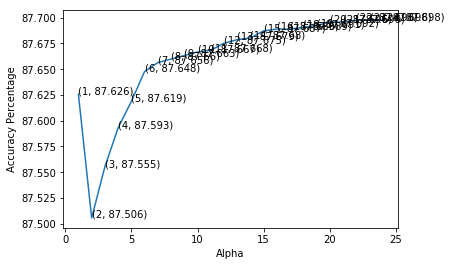

the Accuracy for each Alpha is :  [87.626 87.506 87.555 87.593 87.619 87.648 87.656 87.66  87.663 87.667
 87.668 87.675 87.679 87.68  87.687 87.689 87.689 87.691 87.692 87.696
 87.696 87.698 87.698 87.698]
*********************************************************************
optimal Alpha is:  22

The optimal value of alpha is:  22  With  F1 Score


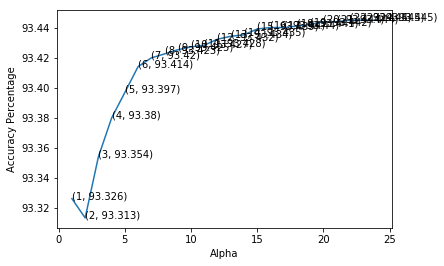

the Accuracy for each Alpha is :  [93.326 93.313 93.354 93.38  93.397 93.414 93.42  93.423 93.425 93.427
 93.428 93.432 93.434 93.435 93.439 93.44  93.44  93.441 93.442 93.444
 93.444 93.445 93.445 93.445]
*********************************************************************
optimal Alpha is:  22

The optimal value of alpha is:  1  With  Precision Score


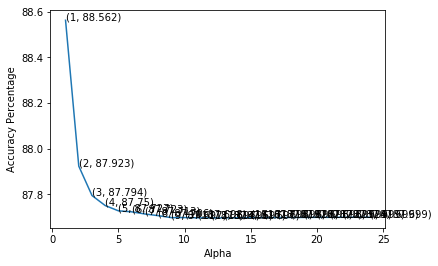

the Accuracy for each Alpha is :  [88.562 87.923 87.794 87.75  87.727 87.723 87.713 87.706 87.697 87.698
 87.697 87.696 87.697 87.697 87.698 87.698 87.698 87.698 87.698 87.699
 87.699 87.699 87.699 87.699]
*********************************************************************
optimal Alpha is:  1

The optimal value of alpha is:  22  With  Recall Score


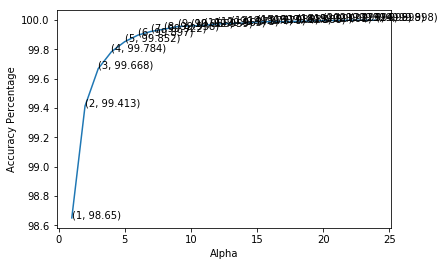

the Accuracy for each Alpha is :  [98.65  99.413 99.668 99.784 99.852 99.897 99.922 99.938 99.955 99.959
 99.963 99.973 99.977 99.979 99.986 99.988 99.988 99.99  99.992 99.996
 99.996 99.998 99.998 99.998]
*********************************************************************
optimal Alpha is:  22

The optimal value of alpha is:  1  With  AUC


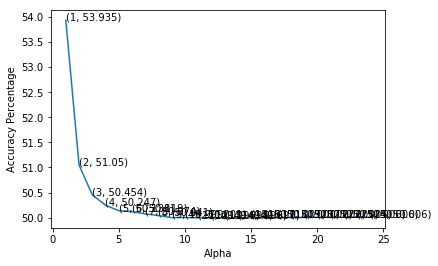

the Accuracy for each Alpha is :  [53.935 51.05  50.454 50.247 50.138 50.119 50.074 50.041 49.999 50.001
 49.996 49.994 49.996 49.997 50.    50.001 50.001 50.002 50.003 50.005
 50.005 50.006 50.006 50.006]
*********************************************************************
optimal Alpha is:  1

The optimal value of alpha is:  2  With  Log-Loss


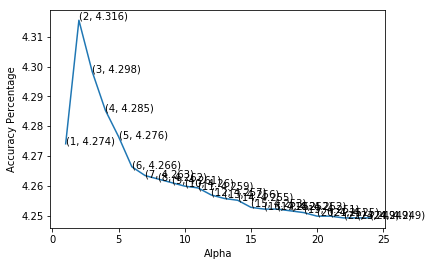

the Accuracy for each Alpha is :  [4.274 4.316 4.298 4.285 4.276 4.266 4.263 4.262 4.261 4.26  4.259 4.257
 4.256 4.255 4.253 4.252 4.252 4.252 4.251 4.25  4.25  4.249 4.249 4.249]
*********************************************************************
optimal Alpha is:  2
#################################################################
With Optimal Alpha-----------------------------------------------
Accuracy Of NB Classifier using Accuracy Score:  87.63666666666666
Accuracy Of NB Classifier using F1 Score:  93.33045620470769
Accuracy Of NB Classifier Precision Score:  88.64257412214783
Accuracy Of NB Classifier using Recall Sscore:  98.54186443895956
Area Under The Curve is :  0.5390940425222194
Log Loss val can be 0 to infinity, 0 is best Our LogLoss is: 4.270232677005971
############# Confusion Matrix ###############
TPR :0.985419,TNR : 0.092769,FNR : 0.014581,FPR: 0.907231


In [290]:
getAlpha_and_Show_Accuracy(x,y,30)

## TF_IDF

In [293]:
final_tf_idf.shape

(364171, 2910192)

In [294]:
# Total data frame
x = final_tf_idf[0:100000]

# this is only Score/rating  of data
y = final_scores[0:100000]



The optimal value of alpha is:  3  With  Accuracy Score


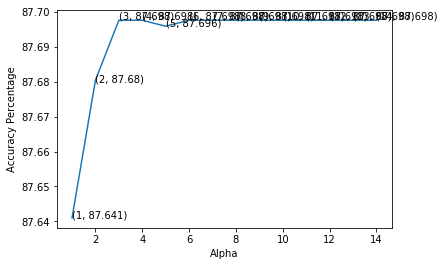

the Accuracy for each Alpha is :  [87.641 87.68  87.698 87.698 87.696 87.698 87.698 87.698 87.698 87.698
 87.698 87.698 87.698 87.698]
*********************************************************************
optimal Alpha is:  3

The optimal value of alpha is:  6  With  F1 Score


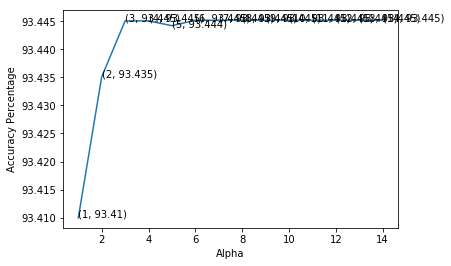

the Accuracy for each Alpha is :  [93.41  93.435 93.445 93.445 93.444 93.445 93.445 93.445 93.445 93.445
 93.445 93.445 93.445 93.445]
*********************************************************************
optimal Alpha is:  6

The optimal value of alpha is:  1  With  Precision Score


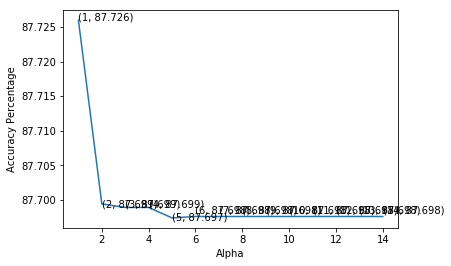

the Accuracy for each Alpha is :  [87.726 87.699 87.699 87.699 87.697 87.698 87.698 87.698 87.698 87.698
 87.698 87.698 87.698 87.698]
*********************************************************************
optimal Alpha is:  1

The optimal value of alpha is:  6  With  Recall Score


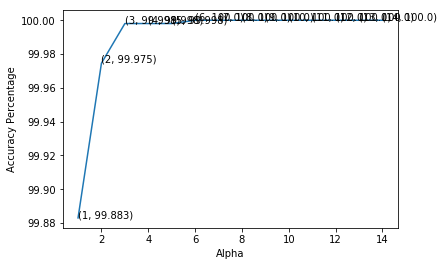

the Accuracy for each Alpha is :  [ 99.883  99.975  99.998  99.998  99.998 100.    100.    100.    100.
 100.    100.    100.    100.    100.   ]
*********************************************************************
optimal Alpha is:  6

The optimal value of alpha is:  1  With  AUC


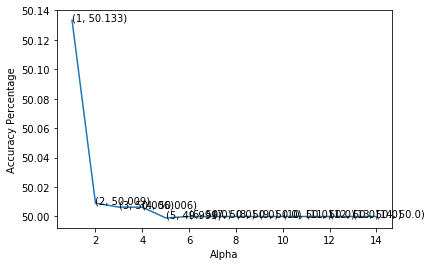

the Accuracy for each Alpha is :  [50.133 50.009 50.006 50.006 49.999 50.    50.    50.    50.    50.
 50.    50.    50.    50.   ]
*********************************************************************
optimal Alpha is:  1

The optimal value of alpha is:  1  With  Log-Loss


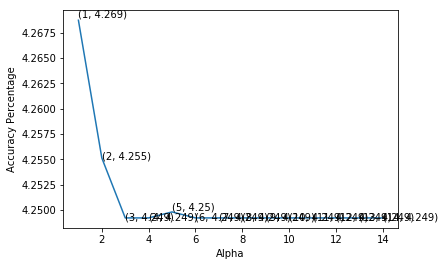

the Accuracy for each Alpha is :  [4.269 4.255 4.249 4.249 4.25  4.249 4.249 4.249 4.249 4.249 4.249 4.249
 4.249 4.249]
*********************************************************************
optimal Alpha is:  1
#################################################################
With Optimal Alpha-----------------------------------------------
Accuracy Of NB Classifier using Accuracy Score:  87.55
Accuracy Of NB Classifier using F1 Score:  93.35042461144047
Accuracy Of NB Classifier Precision Score:  87.87624857545083
Accuracy Of NB Classifier using Recall Sscore:  99.55192709322195
Area Under The Curve is :  0.5043080665711576
Log Loss val can be 0 to infinity, 0 is best Our LogLoss is: 4.300174065963214
############# Confusion Matrix ###############
TPR :0.995519,TNR : 0.013097,FNR : 0.004481,FPR: 0.986903


In [295]:
getAlpha_and_Show_Accuracy(x,y,15)

## W2V

In [200]:
# Total data frame
x = sent_vectors[0:100000]

# this is only Score/rating  of data
y = final_scores[0:100000]



The optimal value of alpha is:  3  With  Accuracy Score


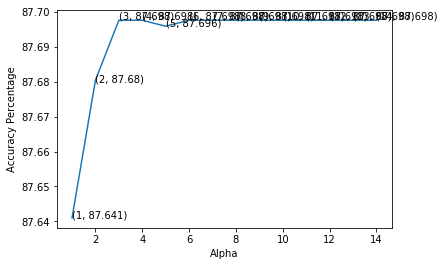

the Accuracy for each Alpha is :  [87.641 87.68  87.698 87.698 87.696 87.698 87.698 87.698 87.698 87.698
 87.698 87.698 87.698 87.698]
*********************************************************************
optimal Alpha is:  3

The optimal value of alpha is:  6  With  F1 Score


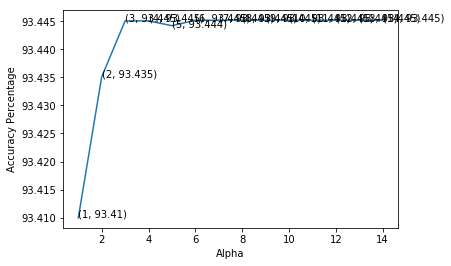

the Accuracy for each Alpha is :  [93.41  93.435 93.445 93.445 93.444 93.445 93.445 93.445 93.445 93.445
 93.445 93.445 93.445 93.445]
*********************************************************************
optimal Alpha is:  6

The optimal value of alpha is:  1  With  Precision Score


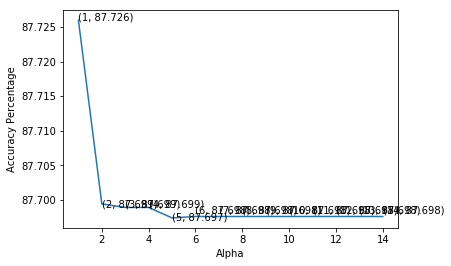

the Accuracy for each Alpha is :  [87.726 87.699 87.699 87.699 87.697 87.698 87.698 87.698 87.698 87.698
 87.698 87.698 87.698 87.698]
*********************************************************************
optimal Alpha is:  1

The optimal value of alpha is:  6  With  Recall Score


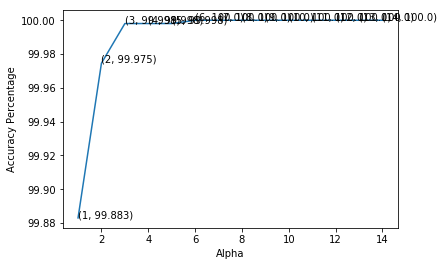

the Accuracy for each Alpha is :  [ 99.883  99.975  99.998  99.998  99.998 100.    100.    100.    100.
 100.    100.    100.    100.    100.   ]
*********************************************************************
optimal Alpha is:  6

The optimal value of alpha is:  1  With  AUC


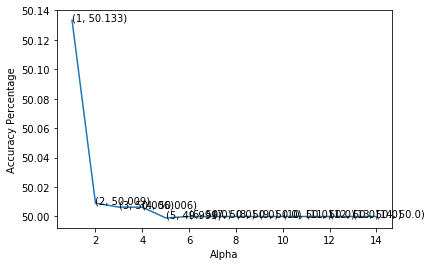

the Accuracy for each Alpha is :  [50.133 50.009 50.006 50.006 49.999 50.    50.    50.    50.    50.
 50.    50.    50.    50.   ]
*********************************************************************
optimal Alpha is:  1

The optimal value of alpha is:  1  With  Log-Loss


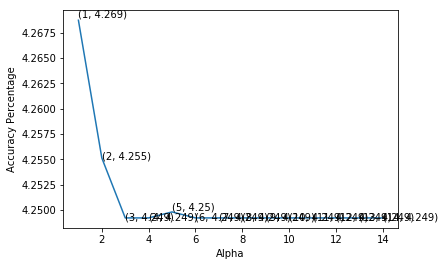

the Accuracy for each Alpha is :  [4.269 4.255 4.249 4.249 4.25  4.249 4.249 4.249 4.249 4.249 4.249 4.249
 4.249 4.249]
*********************************************************************
optimal Alpha is:  1
#################################################################
With Optimal Alpha-----------------------------------------------
Accuracy Of NB Classifier using Accuracy Score:  87.55
Accuracy Of NB Classifier using F1 Score:  93.35042461144047
Accuracy Of NB Classifier Precision Score:  87.87624857545083
Accuracy Of NB Classifier using Recall Sscore:  99.55192709322195
Area Under The Curve is :  0.5043080665711576
Log Loss val can be 0 to infinity, 0 is best Our LogLoss is: 4.300174065963214
############# Confusion Matrix ###############
TPR :0.995519,TNR : 0.013097,FNR : 0.004481,FPR: 0.986903


In [298]:
getAlpha_and_Show_Accuracy(x,y,15)

## Weighted TF_IDF W2V

In [10]:
len(tfidf_sent_vectors)

1000

In [15]:
x = tfidf_sent_vectors[0:350]

y = final_scores[0:350]

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -



The optimal value of alpha is:  27  With  Accuracy Score


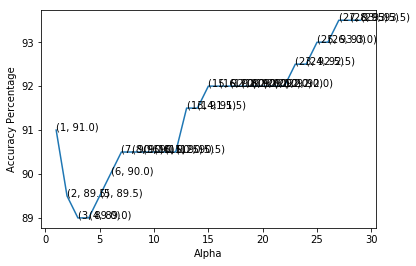

the Accuracy for each Alpha is :  [91.  89.5 89.  89.  89.5 90.  90.5 90.5 90.5 90.5 90.5 90.5 91.5 91.5
 92.  92.  92.  92.  92.  92.  92.  92.  92.5 92.5 93.  93.  93.5 93.5
 93.5]
*********************************************************************
optimal Alpha is:  27

The optimal value of alpha is:  27  With  F1 Score


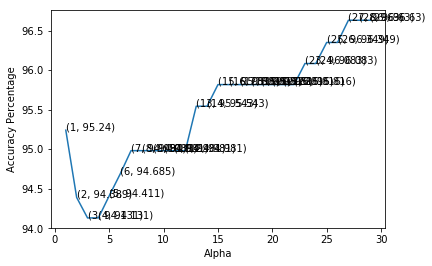

the Accuracy for each Alpha is :  [95.24  94.389 94.131 94.131 94.411 94.685 94.981 94.981 94.981 94.981
 94.981 94.981 95.543 95.543 95.816 95.816 95.816 95.816 95.816 95.816
 95.816 95.816 96.083 96.083 96.349 96.349 96.63  96.63  96.63 ]
*********************************************************************
optimal Alpha is:  27

The optimal value of alpha is:  27  With  Precision Score


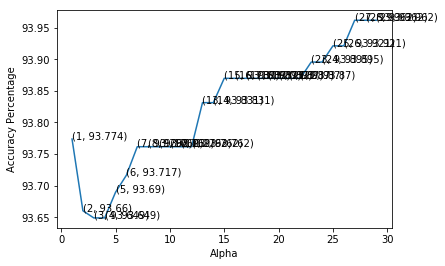

the Accuracy for each Alpha is :  [93.774 93.66  93.649 93.649 93.69  93.717 93.762 93.762 93.762 93.762
 93.762 93.762 93.831 93.831 93.87  93.87  93.87  93.87  93.87  93.87
 93.87  93.87  93.895 93.895 93.921 93.921 93.962 93.962 93.962]
*********************************************************************
optimal Alpha is:  27

The optimal value of alpha is:  27  With  Recall Score


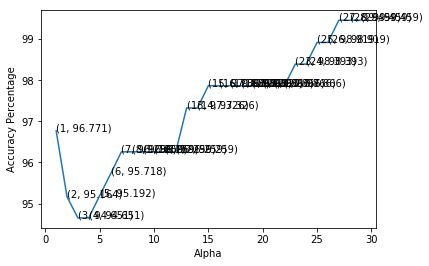

the Accuracy for each Alpha is :  [96.771 95.164 94.651 94.651 95.192 95.718 96.259 96.259 96.259 96.259
 96.259 96.259 97.326 97.326 97.866 97.866 97.866 97.866 97.866 97.866
 97.866 97.866 98.393 98.393 98.919 98.919 99.459 99.459 99.459]
*********************************************************************
optimal Alpha is:  27

The optimal value of alpha is:  27  With  AUC


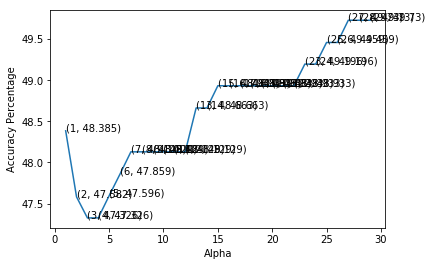

the Accuracy for each Alpha is :  [48.385 47.582 47.326 47.326 47.596 47.859 48.129 48.129 48.129 48.129
 48.129 48.129 48.663 48.663 48.933 48.933 48.933 48.933 48.933 48.933
 48.933 48.933 49.196 49.196 49.459 49.459 49.73  49.73  49.73 ]
*********************************************************************
optimal Alpha is:  27

The optimal value of alpha is:  3  With  Log-Loss


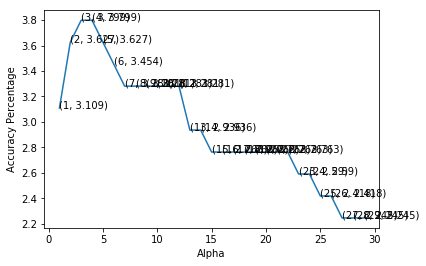

the Accuracy for each Alpha is :  [3.109 3.627 3.799 3.799 3.627 3.454 3.281 3.281 3.281 3.281 3.281 3.281
 2.936 2.936 2.763 2.763 2.763 2.763 2.763 2.763 2.763 2.763 2.59  2.59
 2.418 2.418 2.245 2.245 2.245]
*********************************************************************
optimal Alpha is:  3
#################################################################
With Optimal Alpha-----------------------------------------------
Accuracy Of NB Classifier using Accuracy Score:  83.80952380952381
Accuracy Of NB Classifier using F1 Score:  91.09947643979058
Accuracy Of NB Classifier Precision Score:  89.69072164948454
Accuracy Of NB Classifier using Recall Sscore:  92.5531914893617
Area Under The Curve is :  0.5082205029013539
Log Loss val can be 0 to infinity, 0 is best Our LogLoss is: 5.592068520836033
############# Confusion Matrix ###############
TPR :0.925532,TNR : 0.090909,FNR : 0.074468,FPR: 0.909091


In [16]:
getAlpha_and_Show_Accuracy(x,y,30)

## Feature Importance

In [12]:
# Total data frame
x = final_tf_idf[0:100000]

# this is only Score/rating  of data
y = final_scores[0:100000]

x_1, x_test, y_1, y_test = cross_validation.train_test_split(x,y, test_size=0.3, random_state=0)
    
x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

NB_Optimal = BernoulliNB(alpha=2, binarize=0.0, class_prior=None, fit_prior=True)
NB_Optimal.fit(x_1,y_1)


BernoulliNB(alpha=2, binarize=0.0, class_prior=None, fit_prior=True)

In [17]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    print(len(feature_names))
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    print(len(clf.coef_[0]))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:")
    print("")
    print("\tPositive: \t\t\tNegative:")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("")
        print("\t%-15s\t\t\t%-15s" % (fn_2,fn_1))

In [18]:
show_most_informative_features(tf_idf_vect,NB_Optimal)

2910192
2910192
These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:

	Positive: 			Negative:

	the            			00 00          

	and            			00 07          

	to             			00 09          

	it             			00 10          

	this           			00 11          

	is             			00 12          

	of             			00 16          

	for            			00 18          

	in             			00 20          

	my             			00 20lb        

	with           			00 24oz        

	that           			00 27          

	have           			00 2lb         

	but            			00 33oz        

	you            			00 34          

	are            			00 40          

	on             			00 49          

	not            			00 50          

	they           			00 58          

	so             			00 60          


### Summary:<br>
-> Here the classifier used is 'NaiveBayes' and found Optimal Alpha using Cross Validation, and used different performance measures like Accuracy, Precision, Recall, F1-Score and calculated FPR,FNR,TPR,TNR using Confusion Matrix, I have Embedded all these in two functions.<br>
-> Used 'coef_' to get the Feature Importance and Printed the top 20 Features for Positive Reviews and Negative Reviews.